In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
insp = inspect(engine)
tables=insp.get_table_names()
cols_measurement= insp.get_columns('measurement')
for col in cols_measurement:
    print(col['name'],col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
cols_station= insp.get_columns('station')
for col in cols_station:
    print(col['name'],col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<function matplotlib.pyplot.show(*args, **kw)>

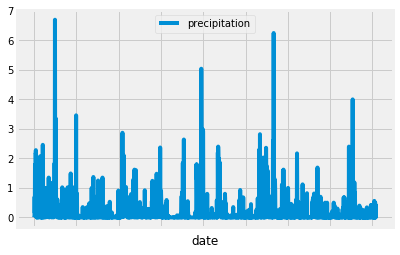

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
date_last=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# print(type(date_last))
date_year_ago=dt.datetime.strptime(date_last,'%Y-%m-%d').date()-dt.timedelta(days=365)
date_year_ago
# # Perform a query to retrieve the data and precipitation scores
query_string=session.query(Measurement.date,(Measurement.prcp).label('precipitation')).\
                filter(Measurement.date>= date_year_ago).statement
# # Save the query results as a Pandas DataFrame and set the index to the date column
measurment_data=pd.read_sql_query(query_string,session.bind,index_col='date')

# Sort the dataframe by date
measurment_data.dropna(inplace=True)
measurment_data.sort_index(inplace=True)
measurment_data
# Use Pandas Plotting with Matplotlib to plot the data
# plt.figure(figsize=(20,20))
measurment_data.plot()
plt.legend(loc='upper center')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     )
plt.show

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurment_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations_available=session.query(Station).distinct(Station.name).count()
stations_available

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations=session.query(Measurement.station.label('Station'),func.count(Measurement.tobs).\
                     label('counts')).\
                     group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
for row in most_active_stations:
    print(f'{row.Station}, {row.counts}')


USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_id=most_active_stations[0].Station
most_active_station_id
station_data=session.query(Measurement.station.label('Station'),func.min(Measurement.tobs).label('MinTemp'),\
                          func.max(Measurement.tobs).label('MaxTemp'),func.avg(Measurement.tobs).label('AvgTemp')).\
                          filter_by(station=most_active_station_id)
#                      group_by(Measurement.station)
for record in station_data:
    print(f"{record.Station},{record.MinTemp},{record.MaxTemp},{round(record.AvgTemp,2)}")

USC00519281,54.0,85.0,71.66


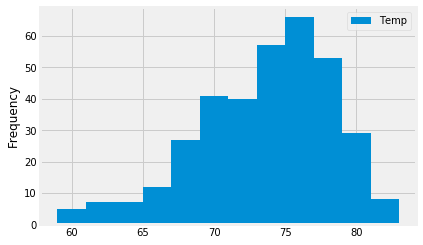

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_temp=session.query(Measurement.date,(Measurement.tobs).label('Temp')).\
                filter_by(station=most_active_station_id).\
                filter(Measurement.date>= date_year_ago).statement
# # Save the query results as a Pandas DataFrame and set the index to the date column
temperature_data=pd.read_sql_query(query_temp,session.bind,index_col='date')
temperature_data.plot.hist(bins=12)
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_previous='2016-02-21'
trip_end_previous='2016-03-01'
trip_temp=calc_temps(trip_start_previous,trip_end_previous)
tripmin=trip_temp[0][0]
tripavg=trip_temp[0][1]
tripmax=trip_temp[0][2]
print(f'Min temperatur :{tripmin},Avg Temperature :{tripavg},Max Temp :{tripmax}')

Min temperatur :60.0,Avg Temperature :70.09375,Max Temp :80.0


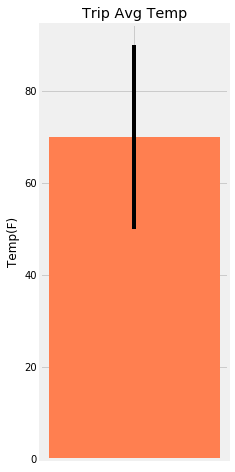

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,8))
plt.bar(x='',height=tripavg,yerr=tripmax-tripmin,color='coral')
# plt.xlim(0,1)
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
 
plt.show()

## Optional Challenge Assignment

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall_per_station=session.query(Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp).\
                     label('Rainfall')).filter(Measurement.station==Station.station).\
                     filter(Measurement.date>=trip_start_previous).filter(Measurement.date<=trip_end_previous).\
                     group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())
for row in total_rainfall_per_station:
    print(f'{row.name},{row.latitude},{row.longitude},{row.elevation},{row.Rainfall}')

KANEOHE 838.1, HI US,21.4234,-157.8015,14.6,0.6
KUALOA RANCH HEADQUARTERS 886.9, HI US,21.5213,-157.8374,7.0,0.48
WAIHEE 837.5, HI US,21.45167,-157.84888999999998,32.9,0.43
WAIMANALO EXPERIMENTAL FARM, HI US,21.33556,-157.71139,19.5,0.34
MANOA LYON ARBO 785.2, HI US,21.3331,-157.8025,152.4,0.06
WAIKIKI 717.2, HI US,21.2716,-157.8168,3.0,0.0
PEARL CITY, HI US,21.3934,-157.9751,11.9,None


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
